In [42]:
import os
import glob
import random
from datetime import datetime
import json
import pickle
import math

import numpy as np

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

import matplotlib.pyplot as plt
%matplotlib inline

from utils import config_gpu, draw_figure
_ = config_gpu()

## brief introduction

In [2]:
model = VGG16()

In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
img_dog = load_img('../data/samples/dog1.jpg', target_size=(224, 224))

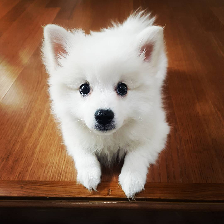

In [5]:
img_dog

In [6]:
arr_dog = img_to_array(img_dog)

In [7]:
arr_dog.shape

(224, 224, 3)

In [8]:
arr_dog.min(), arr_dog.max()

(0.0, 255.0)

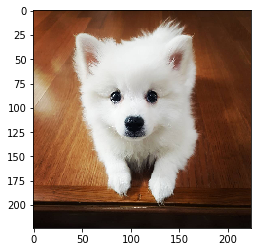

In [9]:
plt.imshow(arr_dog.astype('int64'))

In [10]:
arr_dog = preprocess_input(arr_dog)

In [11]:
arr_dog.shape

(224, 224, 3)

In [12]:
arr_dog.min(), arr_dog.max()

(-123.68, 151.061)

In [13]:
arr_input = np.stack([arr_dog])

In [14]:
probs = model.predict(arr_input)

In [15]:
probs.shape

(1, 1000)

In [16]:
results = decode_predictions(probs)

In [17]:
results

[[('n02112018', 'Pomeranian', 0.9675926),
  ('n02111889', 'Samoyed', 0.019535137),
  ('n02098286', 'West_Highland_white_terrier', 0.003843704),
  ('n02112350', 'keeshond', 0.0020114605),
  ('n02086079', 'Pekinese', 0.0012400536)]]

## transfer learning

In [18]:
vgg16 = VGG16(include_top=False, input_shape=(224, 224, 3))

In [19]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [20]:
len(vgg16.layers)

19

In [21]:
def build_transfer_model(vgg16):
    
    model = Sequential(vgg16.layers)
    
    # train layers close to output layers
    for layer in model.layers[:15]:
        layer.trainable = False
        
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [22]:
model = build_transfer_model(vgg16)

In [23]:
model.compile(
    loss='binary_crossentropy',
    optimizer=SGD(learning_rate=1e-4, momentum=0.9),
    metrics=['accuracy']
)

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [25]:
idg_train = ImageDataGenerator(
    rescale=1/255.,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

In [26]:
batch_size = 32

In [27]:
# for train
img_itr_train = idg_train.flow_from_directory(
    '../data/chap6/img/shrine_temple/train/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

# for validation
img_itr_validation = idg_train.flow_from_directory(
    '../data/chap6/img/shrine_temple/validation/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

Found 600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [28]:
cur_time = datetime.now().strftime('%y%m%d_%H%M')

model_dir = '../model/vgg16_transfer_learning_model_{}/'.format(cur_time)
os.makedirs(model_dir, exist_ok=True)

print('save dir: ', model_dir)

weight_dir = '../model/vgg16_transfer_learning_weight_{}/'.format(cur_time)
os.makedirs(weight_dir, exist_ok=True)

save dir:  ../model/vgg16_transfer_learning_model_200208_1527/


In [29]:
# save network
model_json = os.path.join(model_dir, 'model.json')
with open(model_json, 'w') as f:
    json.dump(model.to_json(), f)
    
# save labels
model_classes = os.path.join(model_dir, 'classes.pkl')
with open(model_classes, 'wb') as f:
    pickle.dump(img_itr_train.class_indices, f)

In [30]:
steps_per_epoch = math.ceil(img_itr_train.samples/batch_size)
validation_steps = math.ceil(img_itr_validation.samples/batch_size)

In [31]:
cp_filepath = os.path.join(weight_dir, 'ep_{epoch: 02d}_ls_{loss:.1f}.h5')

In [32]:
cp = ModelCheckpoint(
    cp_filepath,
    monitor='loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=True,
    mode='auto',
    save_freq=5
)

In [33]:
csv_file_path = os.path.join(model_dir, 'loss.csv')
csv = CSVLogger(csv_file_path, append=True)

In [34]:
n_epoch = 30

In [35]:
history = model.fit_generator(
    img_itr_train,
    steps_per_epoch=steps_per_epoch,
    epochs=n_epoch,
    validation_data=img_itr_validation,
    validation_steps=validation_steps,
    callbacks=[cp, csv]
)

Epoch 1/30
19/19 [==============================] - 21s 1s/step - loss: 0.7102 - accuracy: 0.5583 - val_loss: 0.5295 - val_accuracy: 0.8550
Epoch 2/30
19/19 [==============================] - 13s 701ms/step - loss: 0.5317 - accuracy: 0.7633 - val_loss: 0.4303 - val_accuracy: 0.8550
Epoch 3/30
19/19 [==============================] - 13s 697ms/step - loss: 0.4877 - accuracy: 0.7733 - val_loss: 0.3790 - val_accuracy: 0.8800
Epoch 4/30
19/19 [==============================] - 13s 695ms/step - loss: 0.4239 - accuracy: 0.8267 - val_loss: 0.3194 - val_accuracy: 0.9200
Epoch 5/30
19/19 [==============================] - 14s 713ms/step - loss: 0.3658 - accuracy: 0.8417 - val_loss: 0.2926 - val_accuracy: 0.9100
Epoch 6/30
19/19 [==============================] - 13s 695ms/step - loss: 0.3744 - accuracy: 0.8467 - val_loss: 0.2831 - val_accuracy: 0.9000
Epoch 7/30
19/19 [==============================] - 13s 695ms/step - loss: 0.3551 - accuracy: 0.8433 - val_loss: 0.2805 - val_accuracy: 0.8700
Ep

In [44]:
def get_rand_img_paths(data_dir, n, seed=0, with_labels=False):
    g = os.path.join(data_dir, '*.jpg')
    img_paths = glob.glob(g)
    random.seed(seed)
    random.shuffle(img_paths)
    target_paths = img_paths[:n]
    if with_labels:
        true_labels = [ext_label_from_filepath(x) for x in target_paths]
        return target_paths, true_labels
    else:
        return target_paths


def load_imgs(img_paths, target_size):
    list_imgs = [img_to_array(load_img(path, target_size=target_size))
                 for path in img_paths]
    return np.array(list_imgs)


def load_random_imgs(data_dir, n=8, seed=0, target_size=(224, 224)):
    target_paths, true_labels = get_rand_img_paths(data_dir, n, seed=seed, with_labels=True)
    imgs = load_imgs(target_paths, target_size)
    return imgs, true_labels


def ext_label_from_filepath(img_path):
    target_idx = 0
    return os.path.basename(img_path).split('_')[target_idx]

In [67]:
x_test, true_labels = load_random_imgs(
    '../data/chap6/img/shrine_temple/test/unknown/',
    seed=2
)

In [68]:
x_test.shape, len(true_labels)

((8, 224, 224, 3), 8)

In [69]:
x_test_preproc = preprocess_input(x_test.copy()/255.)

In [70]:
probs = model.predict(x_test_preproc)

In [71]:
probs

array([[0.9533285 ],
       [0.94969916],
       [0.94852555],
       [0.9463414 ],
       [0.95250404],
       [0.953039  ],
       [0.9513615 ],
       [0.9517426 ]], dtype=float32)

In [72]:
def show_test_samples(imgs, probs, class_indices, true_labels):
    pred_labels = get_pred_sample_labels(probs, class_indices)
    labels = [p + '\n' + 'True:' + t for p, t in zip(pred_labels, true_labels)]
    show_img_samples(imgs, labels)
    
    
def get_pred_sample_labels(probs, class_indices):
    class_labels = {idx: label for label, idx in class_indices.items()}
    tmp = '{}:{:.3f}  /  {}:{:.3f}'
    lbls = [tmp.format(class_labels[0], 1- p[0], class_labels[1], p[0])
            for p in probs]
    return lbls


def show_img_samples(imgs, labels, ncols=4, save_fig=None):
    n = len(imgs)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
    for ax, img, label in zip(axes.ravel(), imgs, labels):
        ax = imshow_with_title(ax, img, label)
    if save_fig:
        fig.savefig(save_fig)
    # fig.show()
    
    
def imshow_with_title(ax, img, title):
    ax.imshow(img / 255.)
    ax.set_title(title)
    ax.axis('off')
    return ax

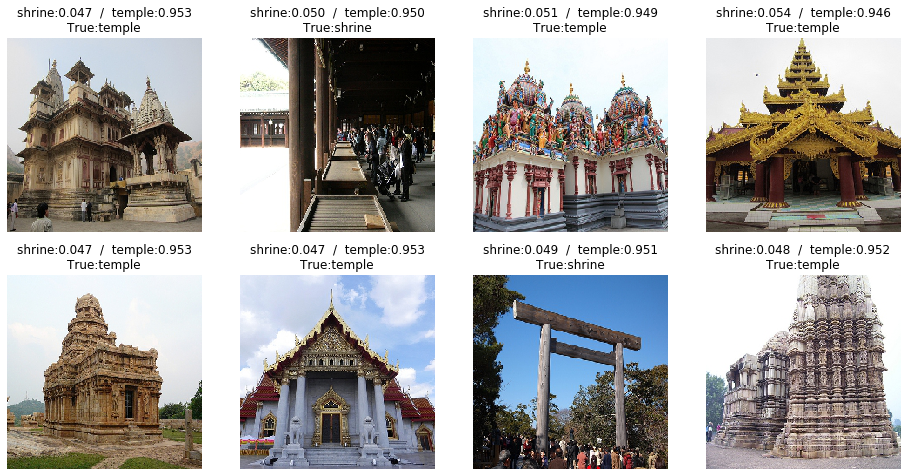

In [73]:
show_test_samples(x_test, probs, img_itr_train.class_indices, true_labels)

In [76]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

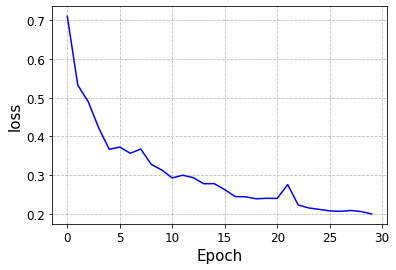

In [78]:
draw_figure(history, 'loss')

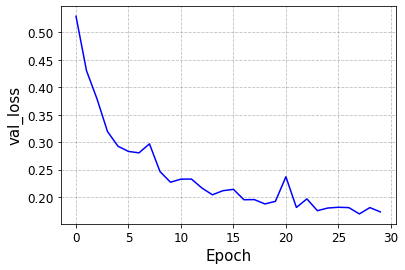

In [79]:
draw_figure(history, 'val_loss')

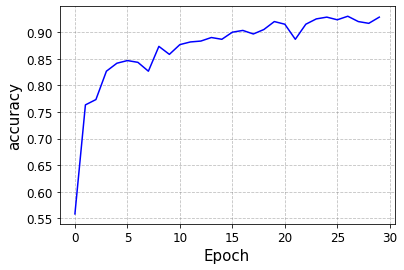

In [80]:
draw_figure(history, 'accuracy')

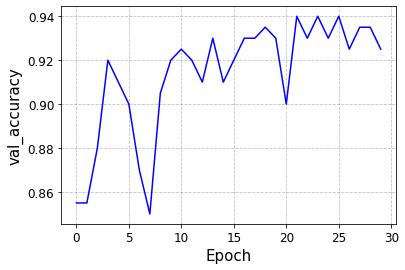

In [81]:
draw_figure(history, 'val_accuracy')